# **Важно!** 

Домашнее задание состоит из нескольких задач, которые вам нужно решить.
*   Баллы выставляются по принципу выполнено/невыполнено.
*   За каждую выполненую задачу вы получаете баллы (количество баллов за задание указано в скобках).

**Инструкция выполнения:** Выполните задания в этом же ноутбуке (места под решения **КАЖДОЙ** задачи обозначены как **#НАЧАЛО ВАШЕГО РЕШЕНИЯ** и **#КОНЕЦ ВАШЕГО РЕШЕНИЯ**)

**Как отправить задание на проверку:** Вам необходимо сохранить ваше решение в данном блокноте и отправить итоговый **файл .IPYNB** в личном сообщении Telegram.

**Срок проверки преподавателем:** домашнее задание проверяется **в течение 3 дней после дедлайна сдачи** с предоставлением обратной связи

# **Прежде чем проверять задания:**

1. Перезапустите **ядро (restart the kernel)**: в меню, выбрать **Ядро (Kernel)**
→ **Перезапустить (Restart)**
2. Затем **Выполнить** **все ячейки (run all cells)**: в меню, выбрать **Ячейка (Cell)**
→ **Запустить все (Run All)**.

После ячеек с заданием следуют ячейки с проверкой **с помощью assert.**

Если в коде есть ошибки, assert выведет уведомление об ошибке.

Если в коде нет ошибок, assert отработает без вывода дополнительной информации.

---

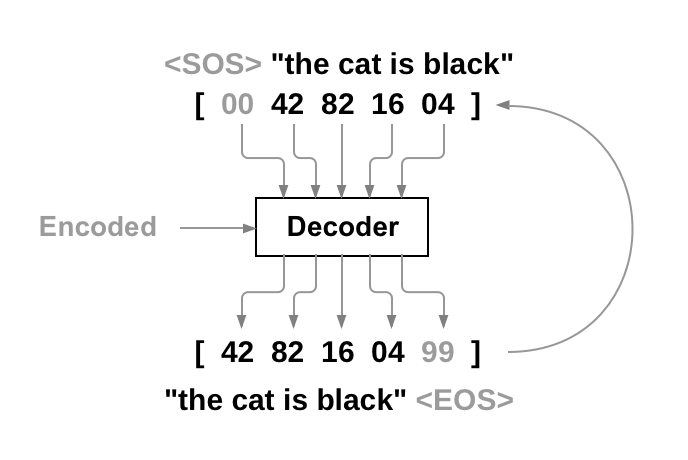

In [1]:
"""
Перевод с Sequence to Sequence Network и Attention
*******************************************************************************
https://github.com/pytorch/tutorials/blob/main/intermediate_source/seq2seq_translation_tutorial.py

В этом домашнем задании мы будем обучать нейронную сеть переводу с английского на русский.

Это стало возможным благодаря простым, но мощным идеям seq2seq <https://arxiv.org/abs/1409.3215 >.
Две рекуррентные нейронные сети работают вместе, преобразуя одну последовательность в
другую. Сеть кодировщиков преобразует входную последовательность в вектор,
а сеть декодеров разворачивает этот вектор в новую последовательность.
"""
from IPython.display import Image
Image(filename='decoder@2x.png')

In [2]:
"""
Чтобы улучшить эту модель, мы будем использовать механизм внимания <https://arxiv.org/abs/1409.0473v7 >,
который позволяет декодеру научиться фокусироваться на определенном диапазоне входной последовательности.

Рекомендуемые источники:
-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user
-  `Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation <https://arxiv.org/abs/1406.1078>
-  `Sequence to Sequence Learning with Neural Networks <https://arxiv.org/abs/1409.3215>
-  `Neural Machine Translation by Jointly Learning to Align and Translate <https://arxiv.org/abs/1409.0473>
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>
""";

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


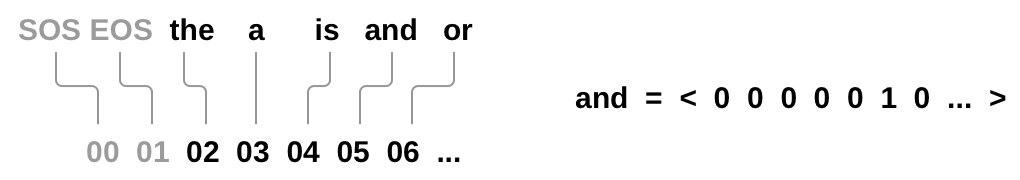

In [4]:
"""
Загрузка файлов данных
=======================

Данные для этого проекта представляют собой набор из множества тысяч пар перевода с английского на русский.

Сайты https://tatoeba.org/ и https://www.manythings.org/anki/ содержат датасеты по языкам

Пары английского и русского языков слишком велики для включения в репозиторий, поэтому
перед продолжением загрузите файл ``eng-rus.txt``. Файл представляет собой табулированный
список пар перевода:

I am cold.    Я замерз.

#####################################################################
Аналогично кодированию символов, используемому в учебниках по символьным RNN,
мы будем представлять каждое слово в языке как вектор one-hot, или огромный вектор,
состоящий из нулей, за исключением одной единицы (в индексе слова). По сравнению
с десятками символов, которые могут существовать в языке, слов намного больше,
поэтому вектор кодирования гораздо больше. Мы, однако, обрежем данные,
чтобы использовать всего несколько тысяч слов на каждом языке.
"""
Image(filename='word-encoding@2x.png')

In [5]:
"""
Нам понадобится уникальный индекс для каждого слова, чтобы использовать их в качестве входов и целей
для сетей позже. Чтобы отслеживать все это, мы будем использовать вспомогательный класс
под названием ``Lang``, который имеет словари word → index (``word2index``) и index → word
(``index2word``), а также счетчик каждого слова ``word2count``, который будет использоваться для замены редких слов позже.
"""

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
""" Все файлы в формате Unicode, для упрощения мы преобразуем символы Unicode в ASCII,
приведем все к нижнему регистру и уберем большинство знаков пунктуации.
Преобразование Unicode-строки в обычный ASCII благодаря https://stackoverflow.com/a/518232/2809427 """

def unicodeToAscii(s):
    # Преобразование Unicode-строки в ASCII, убирая диакритические знаки
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Приведение к нижнему регистру, удаление пробелов в начале и конце строки
# замена некоторых знаков препинания на пробел перед ними
# замена всех символов, не являющихся буквами, на пробел
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Я!?]+", r" ", s)
    return s.strip()

In [7]:
"""
Для чтения файла данных мы разделим файл на строки, а затем разделим
 строки на пары. Файлы представлены в формате lang1 → lang2."""

def readLangs(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(f'{lang1}-{lang2}.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines if l.strip()]

    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
"""Поскольку примеров предложений очень много, и мы хотим обучить
что-то быстро, мы обрежем набор данных до относительно коротких и
простых предложений. Здесь максимальная длина составляет 10 слов
(включая конечные знаки препинания), и мы фильтруем предложения,
которые переводятся в форму "Я" или "Он" и так далее (с учетом
ранее замененных апострофов)."""

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
"""
Полный процесс подготовки данных заключается в следующем:

- Прочитать текстовый файл и разбить на строки, разбить строки на пары
- Нормализовать текст, фильтровать по длине и содержимому
- Составляйте списки слов из парных предложений """


def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'rus')
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 32221 sentence pairs
Counting words...
Counted words:
eng 4422
rus 10770
['you re a little early', 'ты немного рано']


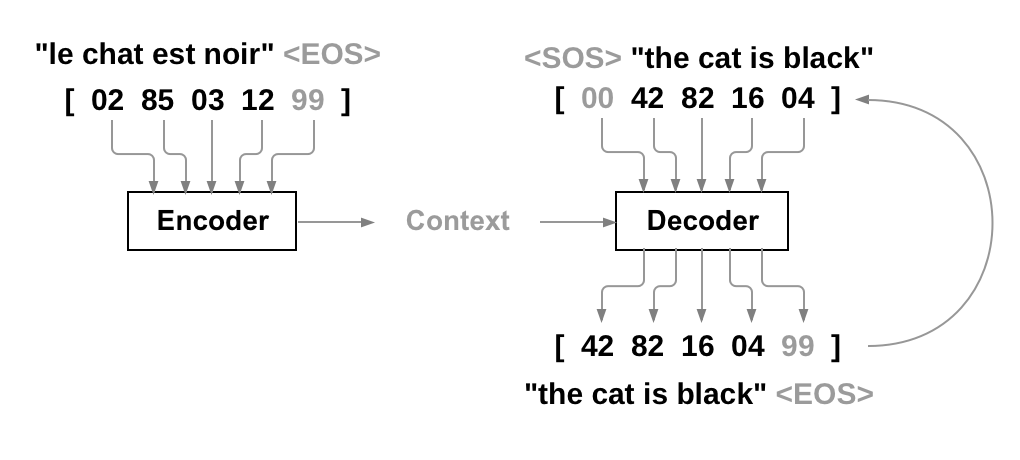

In [10]:
"""
The Seq2Seq Model
=================

Рекуррентная нейронная сеть, или RNN, - это сеть, которая работает с последовательностью и использует свой
собственный вывод в качестве входа для последующих шагов.

`Сеть последовательности к последовательности <https://arxiv.org/abs/1409.3215>`__, или
сеть seq2seq, или `сеть кодировщик-декодировщик
<https://arxiv.org/abs/1406.1078>`__, - это модель, состоящая из двух RNN, называемых кодировщиком и декодировщиком.
Кодировщик считывает входную последовательность и выводит один вектор, а декодировщик считывает этот вектор,
чтобы произвести выходную последовательность.

В отличие от предсказания последовательности с использованием одной RNN, где каждый вход соответствует выходу,
модель seq2seq освобождает нас от длины и порядка последовательности, что делает ее идеальной для перевода между двумя языками.

Рассмотрим предложение ``Je ne suis pas le chat noir`` → ``I am not the black cat``. Большинство слов во входном предложении
имеют прямой перевод в выходном предложении, но расположены в слегка различном порядке, например, ``chat noir`` и ``black cat``.
Из-за конструкции ``ne/pas`` во входном предложении также на одно слово больше. Было бы трудно создать правильный перевод
непосредственно из последовательности входных слов.

С помощью модели seq2seq кодировщик создает один вектор, который, в идеальном случае, кодирует "смысл" входной последовательности в
один вектор - одну точку в некотором N-мерном пространстве предложений.
"""
# print(image_to_base64("seq2seq.png"))
Image(filename='seq2seq@2x.png')

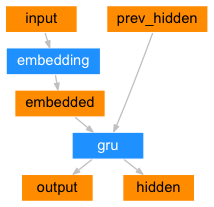

In [11]:
"""
The Encoder (Кодировщик)
-----------

Кодировщик сети seq2seq - это RNN, который выводит некоторое значение для
каждого слова из входного предложения. Для каждого входного слова кодер
выводит вектор и скрытое состояние и использует скрытое состояние для
следующего входного слова."""

# print(image_to_base64("encoder-network.png"))
Image(filename='encoder-network.png')

In [12]:
"""
Задание:

**Цель:**
Написать класс `EncoderRNN` для использования в модели seq2seq для задачи машинного перевода.

**Требования:**
1. В конструкторе класса `__init__`:
   - Принимайте параметры `input_size`, `hidden_size` и `dropout_p` (с вероятностью отсева 0.1 по умолчанию).
   - Задайте атрибут `hidden_size` для хранения размера скрытого состояния.
   - Используйте встроенные слои PyTorch (`nn.Embedding` и `nn.GRU`) для создания эмбеддингов входных данных и слоя GRU.
   - параметры при инициализации nn.Embedding: input_size, hidden_size
   - параметры при инициализации nn.GRU: hidden_size, hidden_size, batch_first=True
   - Включите слой `nn.Dropout` с вероятностью отсева `dropout_p`.

   В методе forward:
   - Принимайте входные данные input.
   - Пропустите эти данные через слои Embedding, GRU и Dropout.
   - Верните выход и скрытое состояние.

В случае затруднений можно обратиться к:
https://github.com/pytorch/tutorials/blob/main/intermediate_source/seq2seq_translation_tutorial.py
"""


class EncoderRNN(nn.Module):
   # НАЧАЛО ВАШЕГО РЕШЕНИЯ
   def __init__(self, input_size: int, hidden_size: int, dropout_p: float = 0.1) -> None:
      super().__init__()
      self._hidden_size = hidden_size
      self._embeddings = nn.Embedding(input_size, self._hidden_size)
      self._gru = nn.GRU(self._hidden_size, self._hidden_size,batch_first=True)
      self._dropout = nn.Dropout(dropout_p)

   def forward(self, x:torch.Tensor) -> torch.Tensor:
      out = self._embeddings(x)
      out, hd = self._gru(out)
      out = self._dropout(out)
      return out, hd

   # КОНЕЦ ВАШЕГО РЕШЕНИЯ

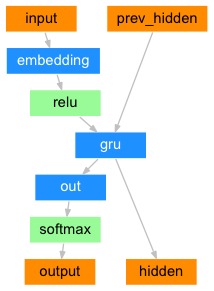

In [13]:
"""
Декодер
-----------

Декодер - это другой RNN, который принимает выходные векторы кодера и
выводит последовательность слов для создания перевода."""

# print(image_to_base64("decoder-network.png"))
Image(filename='decoder-network.png')

In [14]:
"""
Простой декодер
^^^^^^^^^^^^^^

В простейшем декодере seq2seq мы используем только последний выходной сигнал кодера.
Этот последний вывод иногда называют *контекстным вектором*, поскольку он кодирует
контекст из всей последовательности. Этот контекстный вектор используется в качестве
начальное скрытое состояние декодера.

На каждом шаге декодирования декодеру выдается входной токен и
скрытое состояние. Начальный входной токен - это начало строки `<SOS>`
токен, и первое скрытое состояние - это вектор контекста (кодировщик
последнее скрытое состояние).

Задание:

**Цель:**
Реализовать класс `DecoderRNN` для использования в модели seq2seq для задачи машинного перевода.

**Требования:**
1. Класс должен наследоваться от `nn.Module`.
2. В конструкторе класса `__init__`:
   - Принимайте параметры `hidden_size` и `output_size`.
   - Используйте встроенные слои PyTorch (`nn.Embedding`, `nn.GRU` и `nn.Linear`) для создания эмбеддингов выходных данных,
   слоя GRU и линейного слоя для выходных данных.

3. Реализуйте метод `forward`:
   - Принимайте `encoder_outputs`, `encoder_hidden` и `target_tensor` (по умолчанию `None`).
   - Инициализируйте начальный вход `decoder_input` и скрытое состояние `decoder_hidden`.
   - В цикле для каждого временного шага вызывайте метод `forward_step` для обновления `decoder_input` и `decoder_hidden`.
   - Собирайте выходные данные `decoder_outputs` в список.
   - Если предоставлен `target_tensor`, используйте метод "принуждения учителя" (teacher forcing) для обновления `decoder_input`. В противном случае используйте предсказания модели.
   - Конкатенируйте список `decoder_outputs` и примените логарифмическую функцию Softmax (`F.log_softmax`).
   - Верните `decoder_outputs`, `decoder_hidden` и `None` для согласованности с циклом обучения.

4. Реализуйте метод `forward_step`:
   - Принимайте `input` и `hidden`.
   - Примените эмбеддинги, функцию активации ReLU и слой GRU к `input` и `hidden`.
   - Примените линейный слой к полученному выводу.
   - Верните `output` и `hidden`.

В случае затруднений можно обратиться к:
https://github.com/pytorch/tutorials/blob/main/intermediate_source/seq2seq_translation_tutorial.py
"""

class DecoderRNN(nn.Module):
   # НАЧАЛО ВАШЕГО РЕШЕНИЯ
   def __init__(self, hidden_size:int, output_size:int) -> None:
      super().__init__()
      self._gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
      self._embedding = nn.Embedding(output_size, hidden_size)
      self._linear = nn.Linear(hidden_size, output_size)

   def _forward_step(self, input:torch.Tensor, hidden:torch.Tensor):
      out = self._embedding(input)
      out = nn.functional.relu(out)
      out, hd = self._gru(input, hidden)
      out = self._linear(out)
      return out, hd

   def forward(self, encoder_out:torch.Tensor, encoder_hd:torch.Tensor, tgt_tensor:torch.Tensor=None):
      decoder_input = torch.zeros(encoder_out.size(0), 1, dtype=torch.long, device=self.device)
      decoder_hd = encoder_hd
      decoder_outputs = []

      for step in range(MAX_LENGTH):
         out, decoder_hd = self._forward_step(decoder_input, decoder_hd)
         decoder_outputs.append(out)
         if tgt_tensor is None:
            decoder_input = torch.argmax(out, dim=1, keepdim=True).detach()
         else:
            decoder_input = tgt_tensor[:, step].unsqueeze(1)

      decoder_outputs = torch.cat(decoder_outputs, dim=1)
      decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
      return decoder_outputs, decoder_hd, None

   # КОНЕЦ ВАШЕГО РЕШЕНИЯ

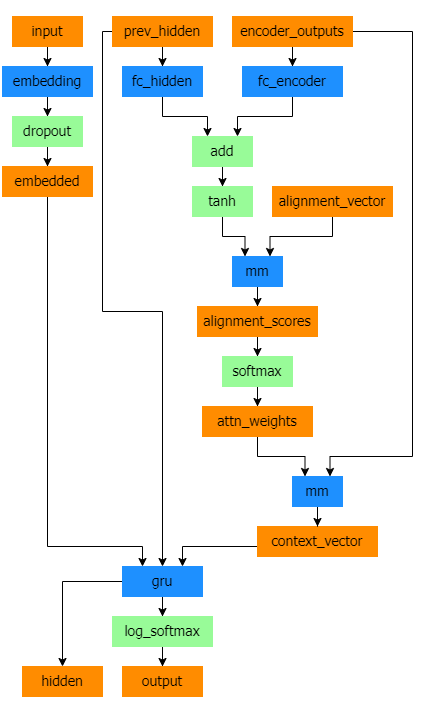

In [15]:
"""
Декодер внимания
^^^^^^^^^^^^^^^^^

Если между кодером и декодером передается только вектор контекста,
то этот единственный вектор несет бремя кодирования всего предложения.

Внимание позволяет сети декодера "фокусироваться" на другой части
выходных данных кодера для каждого шага собственных выходных данных декодера. Сначала
мы вычисляем набор *весов внимания*. Они будут умножены на
выходные векторы кодера для создания взвешенной комбинации. Результат
(называемый в коде `attn_applied`) должен содержать информацию о
эту конкретную часть входной последовательности и, таким образом, помочь декодеру
выбрать правильные выходные слова.
"""


Image(filename='1152PYf.png')

"""
Вычисление весов внимания выполняется с помощью другого уровня прямой
связи `attn`, используя входные данные декодера и скрытое состояние в качестве входных данных.
Поскольку в обучающих данных есть предложения всех размеров, чтобы
фактически создать и обучить этот слой, мы должны выбрать максимальную
длину предложения (входную длину для выходных данных кодера), к которой он может быть применен
. Предложения максимальной длины будут использовать все коэффициенты внимания,
в то время как в более коротких предложениях будут использоваться только первые несколько.
"""

Image(filename='attention-decoder-network.png')

In [16]:
"""
Внимание Богданова, также известное как аддитивное внимание, является широко используемым
механизмом внимания в моделях от последовательности к последовательности, особенно в задачах нейронного
машинного перевода. Он был введен Богдановым и др. в своей
статье <https://arxiv.org/abs/1409.0473 >.
Этот механизм внимания использует изученную модель выравнивания для вычисления
показателей внимания между скрытыми состояниями кодера и декодера. Он использует
нейронную сеть с прямой связью для вычисления оценок выравнивания.

Однако существуют альтернативные доступные механизмы внимания, такие как Luong attention,
который вычисляет баллы внимания путем вычисления точечного произведения между скрытым состоянием декодера
и скрытыми состояниями кодера. Это не связано с нелинейным преобразованием, используемым во внимании Богданова.

В этом уроке мы будем использовать внимание Богданова. Однако было бы полезным
упражнением изучить возможность модификации механизма внимания для использования длительного внимания.
Существуют и другие формы внимания, которые работают по всей длине
# ограничение с использованием подхода относительного положения. Читайте о "местном
# внимание" в книге "Эффективные подходы к нейронной машине, основанной на внимании".
# Перевод <https://arxiv.org/abs/1508.04025 >
"""

"""
**Задание: Реализация Класса BahdanauAttention**

**Цель:**
Реализовать класс `BahdanauAttention` для использования в модели seq2seq для задачи машинного перевода. Механизм внимания по Бахданау является ключевым компонентом для улучшения качества перевода.

**Требования:**
1. Класс `BahdanauAttention` должен наследоваться от `nn.Module`.

2. В конструкторе класса `__init__`:
   - Принимайте параметр `hidden_size`.
   - Создайте три линейных слоя PyTorch (`nn.Linear`) под именами `Wa`, `Ua`, и `Va`. Используйте `hidden_size` для определения размерности входов и выходов этих слоев.

3. Реализуйте метод `forward`:
   - Принимайте два аргумента, `query` и `keys`.
   - Выполните следующие шаги:
      - Примените линейные преобразования с использованием слоев `Wa` и `Ua` к входам `query` и `keys` соответственно.
      - Примените функцию активации tanh к полученным результам.
      - Сложите результаты преобразований и примените линейное преобразование через слой `Va`.
      - Примените функцию tanh ко всему выражению.
      - Уменьшите размерность на последней оси (squeeze) и добавьте размерность в начале (unsqueeze).
      - Примените функцию Softmax по последней оси.

4. Верните веса внимания (`weights`) и взвешенную сумму ключей (`context`) из метода `forward`.

В случае затруднений можно обратиться к:
https://github.com/pytorch/tutorials/blob/main/intermediate_source/seq2seq_translation_tutorial.py
"""

class BahdanauAttention(nn.Module):
   # НАЧАЛО ВАШЕГО РЕШЕНИЯ
   def __init__(self, hidden_size:int):
      super().__init__()
      self._Wa = nn.Linear(hidden_size, hidden_size)
      self._Ua = nn.Linear(hidden_size, hidden_size)
      self._Va = nn.Linear(hidden_size, 1)

   def forward(self, query:torch.Tensor ,keys:torch.Tensor):
      att = self._Va(torch.tanh(self._Wa(query) + self._Ua(keys)))
      att = att.squeeze(2).unsqueeze(1)
      weights = F.softmax(att, dim=-1)
      context = torch.bmm(weights, keys)

      return context, weights

   # КОНЕЦ ВАШЕГО РЕШЕНИЯ


In [17]:
"""
**Задание: Реализация Класса AttnDecoderRNN**

**Цель:**
Реализовать класс `AttnDecoderRNN` для использования в модели seq2seq для задачи машинного перевода.
Этот класс использует механизм внимания по Богданову (`BahdanauAttention`).
Существуют и другие формы внимания, которые работают по длине ограничение с использованием
подхода относительного положения <https://arxiv.org/abs/1508.04025 >.

**Требования:**
1. Класс `AttnDecoderRNN` должен наследоваться от `nn.Module`.

2. В конструкторе класса `__init__`:
   - Принимайте параметры `hidden_size`, `output_size` и `dropout_p` (по умолчанию 0.1).
   - Создайте встроенный слой PyTorch (`nn.Embedding`) под именем `embedding` для создания эмбеддингов выходных данных.
   - Используйте класс `BahdanauAttention` (`attention`) для создания механизма внимания.
   - Создайте слой GRU (`nn.GRU`) с учетом входов и выходов для эмбеддингов и контекста внимания.
   - Используйте линейный слой (`nn.Linear`) для создания выходного слоя.
   - Включите dropout с вероятностью `dropout_p` после эмбеддингов.

3. Реализуйте метод `forward`:
   - Принимайте `encoder_outputs`, `encoder_hidden` и `target_tensor` (по умолчанию `None`).
   - Инициализируйте начальный вход `decoder_input` и скрытое состояние `decoder_hidden`.
   - В цикле для каждого временного шага вызывайте метод `forward_step` для обновления `decoder_input`, `decoder_hidden` и получения весов внимания (`attn_weights`).
   - Собирайте выходные данные `decoder_outputs` и веса внимания `attentions` в списки.
   - Если предоставлен `target_tensor`, используйте метод "принуждения учителя" (teacher forcing) для обновления `decoder_input`. В противном случае используйте предсказания модели.
   - Конкатенируйте список `decoder_outputs` и примените логарифмическую функцию Softmax (`F.log_softmax`).
   - Верните `decoder_outputs`, `decoder_hidden` и `attentions`.

4. Реализуйте метод `forward_step`:
   - Принимайте `input`, `hidden` и `encoder_outputs`.
   - Примените эмбеддинги с dropout к `input`.
   - Переставьте размерности скрытого состояния `hidden` для использования в механизме внимания.
   - Вызовите метод `forward` механизма внимания (`BahdanauAttention`) для получения контекста внимания (`context`) и весов внимания (`attn_weights`).
   - Объедините эмбеддинги и контекст внимания.
   - Примените GRU к объединенному входу и скрытому состоянию.
   - Примените линейный слой к выходу GRU.
   - Верните `output`, `hidden` и `attn_weights`.

В случае затруднений можно обратиться к:
https://github.com/pytorch/tutorials/blob/main/intermediate_source/seq2seq_translation_tutorial.py
"""

class AttnDecoderRNN(nn.Module):
   # НАЧАЛО ВАШЕГО РЕШЕНИЯ
   def __init__(self, hidden_size, output_size, dropout_p=0.1):
      super(AttnDecoderRNN, self).__init__()
      self.embedding = nn.Embedding(output_size, hidden_size)
      self.attention = BahdanauAttention(hidden_size)
      self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
      self.out = nn.Linear(hidden_size, output_size)
      self.dropout = nn.Dropout(dropout_p)

   def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
      batch_size = encoder_outputs.size(0)
      decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
      decoder_hidden = encoder_hidden
      decoder_outputs = []
      attentions = []

      for i in range(MAX_LENGTH):
         decoder_output, decoder_hidden, attn_weights = self.forward_step(
               decoder_input, decoder_hidden, encoder_outputs
         )
         decoder_outputs.append(decoder_output)
         attentions.append(attn_weights)

         if target_tensor is not None:
               # Teacher forcing: Feed the target as the next input
               decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
         else:
               # Without teacher forcing: use its own predictions as the next input
               _, topi = decoder_output.topk(1)
               decoder_input = topi.squeeze(-1).detach()  # detach from history as input

      decoder_outputs = torch.cat(decoder_outputs, dim=1)
      decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
      attentions = torch.cat(attentions, dim=1)

      return decoder_outputs, decoder_hidden, attentions


   def forward_step(self, input, hidden, encoder_outputs):
      embedded =  self.dropout(self.embedding(input))

      query = hidden.permute(1, 0, 2)
      context, attn_weights = self.attention(query, encoder_outputs)
      input_gru = torch.cat((embedded, context), dim=2)

      output, hidden = self.gru(input_gru, hidden)
      output = self.out(output)

      return output, hidden, attn_weights
   # КОНЕЦ ВАШЕГО РЕШЕНИЯ

In [18]:
"""
Обучение
========

Подготовка обучающих данных
-----------------------

Для обучения для каждой пары нам понадобится входной тензор (индексы
слов во входном предложении) и целевой тензор (индексы слов в
целевом предложении). При создании этих векторов мы добавим токен
EOS к обеим последовательностям.
"""

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'rus')

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [19]:
"""
Обучение модели
------------------

Для обучения мы прогоняем входное предложение через кодировщик и отслеживаем
каждый вывод и последнее скрытое состояние. Затем декодеру передается
токен `<SOS>` в качестве его первого входного сигнала, а последнее скрытое состояние
кодера - в качестве его первого скрытого состояния.

"Принуждение преподавателя" - это концепция использования реальных целевых выходных данных в качестве
каждого следующего входного сигнала, вместо использования предположения декодера в качестве следующего входного сигнала.
Использование принудительного использования учителем приводит к ускорению конвергенции, но "когда используется обученная
сеть, она может демонстрировать
нестабильность <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf >`__.

Вы можете наблюдать выходные данные сетей, созданных учителем, которые читают с
согласованной грамматикой, но далеки от правильного перевода -
интуитивно он научился представлять выходную грамматику и может "
уловить" значение, как только учитель скажет ему первые несколько слов, но он
не научился должным образом составлять предложение
в первую очередь из перевода.

Благодаря свободе, которую дает нам автоград PyTorch, мы можем случайным образом
выберите, использовать принудительное использование учителем или нет, с помощью простого оператора if. Очередь
`teacher_forcing_ratio`, чтобы использовать его в большем количестве.
"""


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
"""
Это вспомогательная функция для печати прошедшего времени и расчетного
оставшегося времени с учетом текущего времени и % прогресса.
"""

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [21]:
"""
Построение графиков результатов
----------------

Построение графика выполняется с помощью matplotlib, используя массив значений потерь
`plot_losses` сохранен во время тренировки.
"""


import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [22]:
"""
Весь тренировочный процесс выглядит примерно так:

- Запуск таймера
- Инициализировать оптимизаторы и критерий
- Создать набор обучающих пар
- Запустить пустой массив потерь для построения графика

Затем мы вызываем `train` и выводим прогресс (%
примеров, время на данный момент, расчетное время) и loss.
"""

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [23]:
"""
Оценка
==========

Оценка в основном такая же, как и обучение, но здесь нет целевых показателей, поэтому
мы просто возвращаем прогнозы декодера самому себе для каждого шага.
Каждый раз, когда он предсказывает слово, мы добавляем его в выходную строку, и если он
предсказывает токен EOS, мы на этом останавливаемся. Мы также сохраняем
выходные данные внимания декодера для последующего отображения.
"""


def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

"""
Мы можем оценить случайные предложения из обучающего набора и распечатать
входные данные, цель и выходные данные, чтобы сделать некоторые субъективные оценки качества:
"""


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 519900 sentence pairs
Trimmed to 32221 sentence pairs
Counting words...
Counted words:
eng 4422
rus 10770
0m 13s (- 4m 24s) (1 5%) 2.4431
0m 27s (- 4m 6s) (2 10%) 1.6201
0m 40s (- 3m 51s) (3 15%) 1.2340
0m 54s (- 3m 37s) (4 20%) 0.9796
1m 7s (- 3m 23s) (5 25%) 0.7975
1m 21s (- 3m 9s) (6 30%) 0.6611
1m 34s (- 2m 55s) (7 35%) 0.5573
1m 48s (- 2m 42s) (8 40%) 0.4793
2m 1s (- 2m 28s) (9 45%) 0.4191
2m 14s (- 2m 14s) (10 50%) 0.3733
2m 28s (- 2m 1s) (11 55%) 0.3380
2m 41s (- 1m 47s) (12 60%) 0.3107
2m 54s (- 1m 33s) (13 65%) 0.2877
3m 7s (- 1m 20s) (14 70%) 0.2703
3m 21s (- 1m 7s) (15 75%) 0.2544
3m 34s (- 0m 53s) (16 80%) 0.2417
3m 47s (- 0m 40s) (17 85%) 0.2313
4m 1s (- 0m 26s) (18 90%) 0.2218
4m 14s (- 0m 13s) (19 95%) 0.2142
4m 27s (- 0m 0s) (20 100%) 0.2080
> we re wasting our time
= мы зря тратим время
< мы зря тратим время время <EOS>

> you re making a big fuss about nothing
= вы делаете из мухи слона
< вы делаете из мухи слона <EOS>

> i m sure it ll happen
= 

<Figure size 640x480 with 0 Axes>

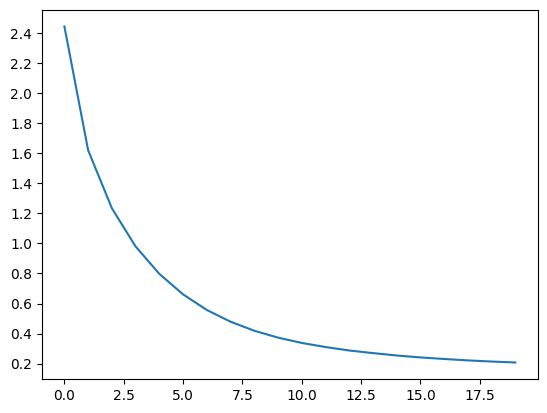

In [24]:
"""
Обучение и оценка
=======================

Имея все эти вспомогательные функции на месте (это выглядит как дополнительная работа, но
упрощает проведение нескольких экспериментов), мы действительно можем
инициализировать сеть и начать обучение.

Помните, что вводимые предложения были тщательно отфильтрованы. Для этого небольшого
набора данных мы можем использовать относительно небольшие сети из 256 скрытых узлов и
одного уровня GRU. Примерно через 40 минут работы с процессором MacBook мы получим некоторые
приемлемые результаты.

.. Примечание::
   Если вы запустите этот блокнот, вы сможете тренироваться, прерывать работу ядра,
   оцените и продолжите обучение позже. Закомментируйте строки, в которых
инициализируются кодер и декодер, и снова запустите `обучить других`.
"""


hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 20, print_every=1, plot_every=1)

#
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

In [25]:
"""
Визуализирующее внимание
---------------------

Полезным свойством механизма внимания является его легко интерпретируемая
результативность. Поскольку он используется для взвешивания конкретных выходных данных кодера
входной последовательности, мы можем представить, что смотрим, где сеть больше всего сосредоточена
на каждом временном шаге.

Вы могли бы просто запустить `plt.matshow(attentions)`, чтобы увидеть вывод внимания
, отображаемый в виде матрицы. Для лучшего просмотра мы проделаем
дополнительную работу по добавлению осей и меток:
"""

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

input = he is not as tall as his father
output = он не такои высокии как его отец <EOS>


/tmp/ipykernel_38737/4207647646.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_38737/4207647646.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


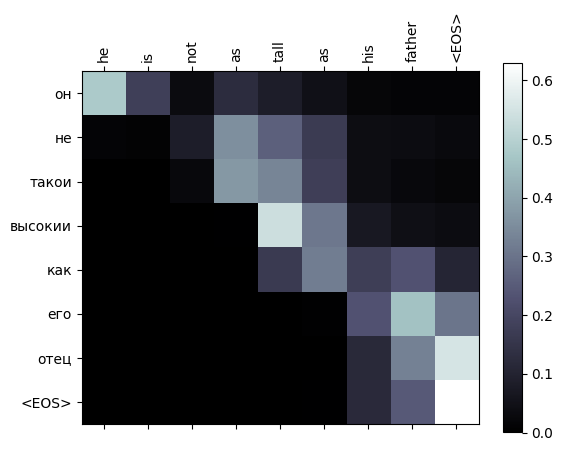

input = i m too tired to drive
output = я слишком устала чтобы вести машину <EOS>


/tmp/ipykernel_38737/4207647646.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_38737/4207647646.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


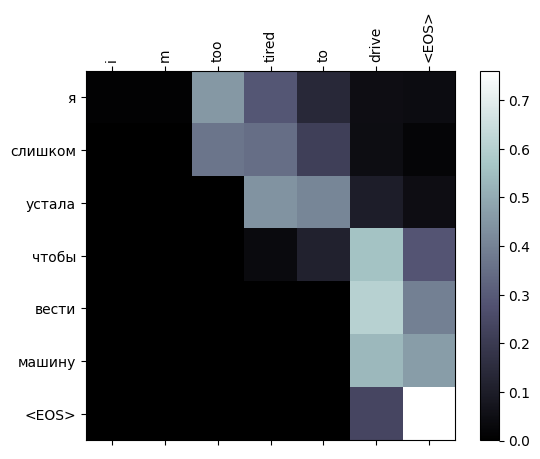

input = i m sorry if this is a silly question
output = прости если это письмо <EOS>


/tmp/ipykernel_38737/4207647646.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_38737/4207647646.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


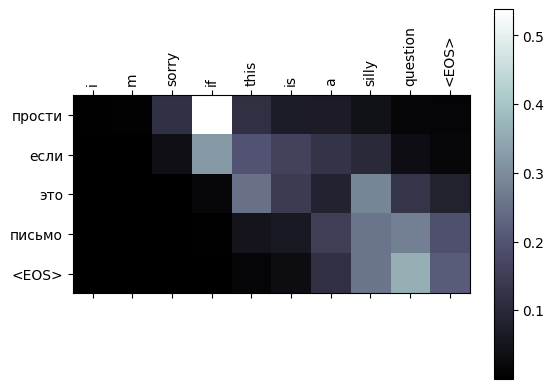

input = i m really proud of you
output = я очень горжусь тобои горжусь <EOS>


/tmp/ipykernel_38737/4207647646.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_38737/4207647646.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


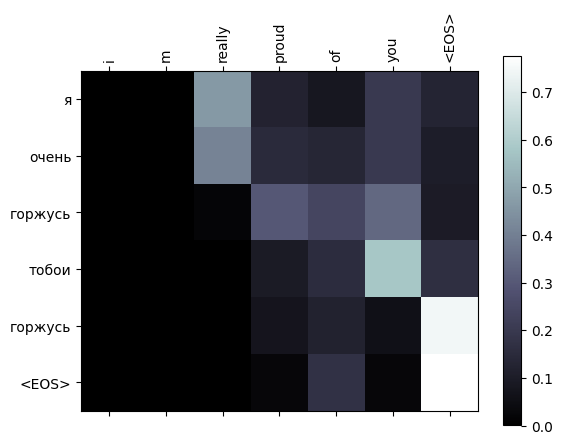

In [26]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('he is not as tall as his father')

evaluateAndShowAttention('i m too tired to drive')

evaluateAndShowAttention('i m sorry if this is a silly question')

evaluateAndShowAttention('i m really proud of you')

In [27]:
"""
Упражнения
=========

-  Попробуйте использовать другой набор данных

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

- Замените вложения предварительно подготовленными вложениями слов, такими как `word2vec` или
   `Перчатка`
- Попробуйте использовать больше слоев, больше скрытых единиц и больше предложений. Сравнивать
   время тренировки и ее результаты.
- Если вы используете файл перевода, в котором пары содержат две одинаковые фразы
   (`I am test \t I am test`), вы можете использовать это как автоэнкодер. Попробуй
это:

   - Тренируйтесь как автоэнкодер
   - Сохранить только сеть кодировщика
   - Обучите новый декодер для перевода оттуда
""";